# Prepare a prediction model for profit of 50 startups data
Do transformations for getting better predictions of profit and make a table containing R^2 value for each prepared model.


## Import Libraries 

In [49]:
# Silence warnings since they do not affect the analysis.
import warnings
warnings.filterwarnings('ignore')

In [50]:
# Data load and manipulation
import pandas as pd
import numpy as np

# Data visualization and analysis.
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Data preprocessing
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

# Machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
import statsmodels.formula.api as smf

# Evaluation metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [51]:
# Matplotlib configurations

# Display interactive plots. Used this since convenient for displaying plots in github.
%matplotlib notebook

# Font and figure size:
# Ref: https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Load data and perform initial checks

In [52]:
startups_df = pd.read_csv('50_Startups.csv')
startups_df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [53]:
# Name of all the states where these companies belong.
startups_df.State.unique()

array(['New York', 'California', 'Florida'], dtype=object)

### Metadata
- R&D Spend -- Research and devolop spend in the past few years
- Administration -- spend on administration in the past few years
- Marketing Spend -- spend on Marketing in the past few years
- State -- states from which data is collected
- Profit  -- profit of each state in the past few years

The data is collected from fifty startups from three cities in USA.

### Objective 
To predict profit of the companies using the rest of the columns as features.

## Exploratory Data Analysis

In [54]:
startups_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


#### Observations:
- 50 records and 5 feratures (4 - input features, 1 - output/target)
- No null values/entries.
- All features have correct datatypes

In [55]:
# Extracting column names and sorting them to appropriate categories.
n_cols = len(startups_df.columns)
numeric_cols = []
cat_cols = []
for i in range(n_cols):
    if startups_df.dtypes[i] == 'float64':
        numeric_cols.append(startups_df.columns[i])
    else:
        cat_cols.append(startups_df.columns[i])

X_cols = [col for col in startups_df.columns if col not in ("Profit")]
y_col = "Profit" 
print("Numeric columns    : ",numeric_cols)
print("Categorical columns: ",cat_cols)
print("Features           : ",X_cols)
print("Target             : ",y_col)

Numeric columns    :  ['R&D Spend', 'Administration', 'Marketing Spend', 'Profit']
Categorical columns:  ['State']
Features           :  ['R&D Spend', 'Administration', 'Marketing Spend', 'State']
Target             :  Profit


## Assumptions check

### 1. Linearity

<IPython.core.display.Javascript object>


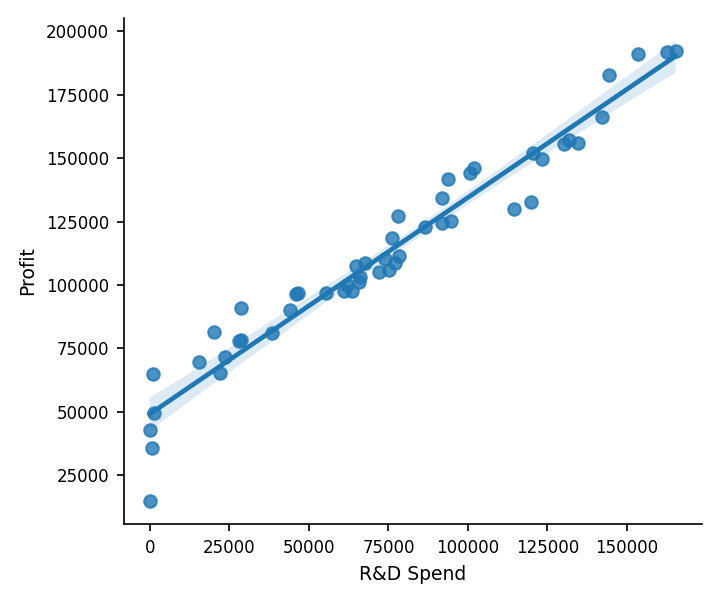

<IPython.core.display.Javascript object>


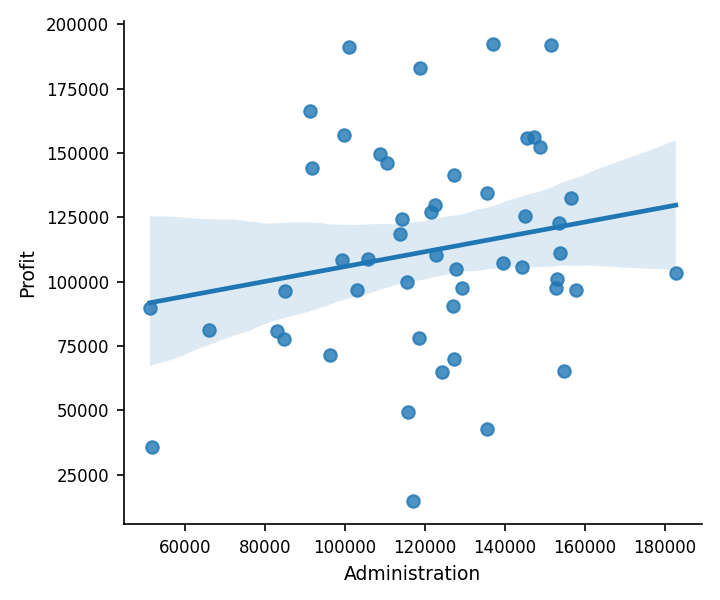

<IPython.core.display.Javascript object>


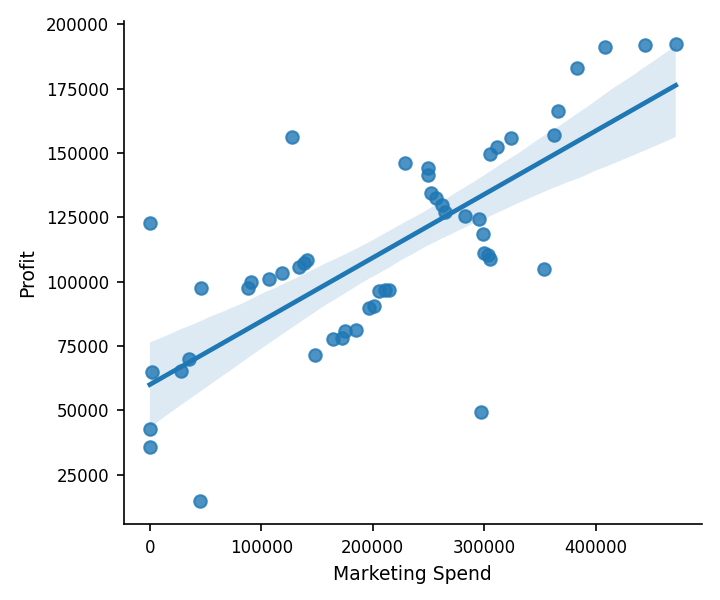

In [56]:
for feature in numeric_cols:
    if feature != 'Profit':
        sns.lmplot(x=feature, y=y_col, data=startups_df, height = 4 , aspect= 1.2)
plt.show()

### Observations:
- Strong linear relationship seen only b/w r&d spend and profit. Rest of the features do not have any linear relationship with profit(target variable). Thus **linearity test fails**

### 2. Normality

<IPython.core.display.Javascript object>


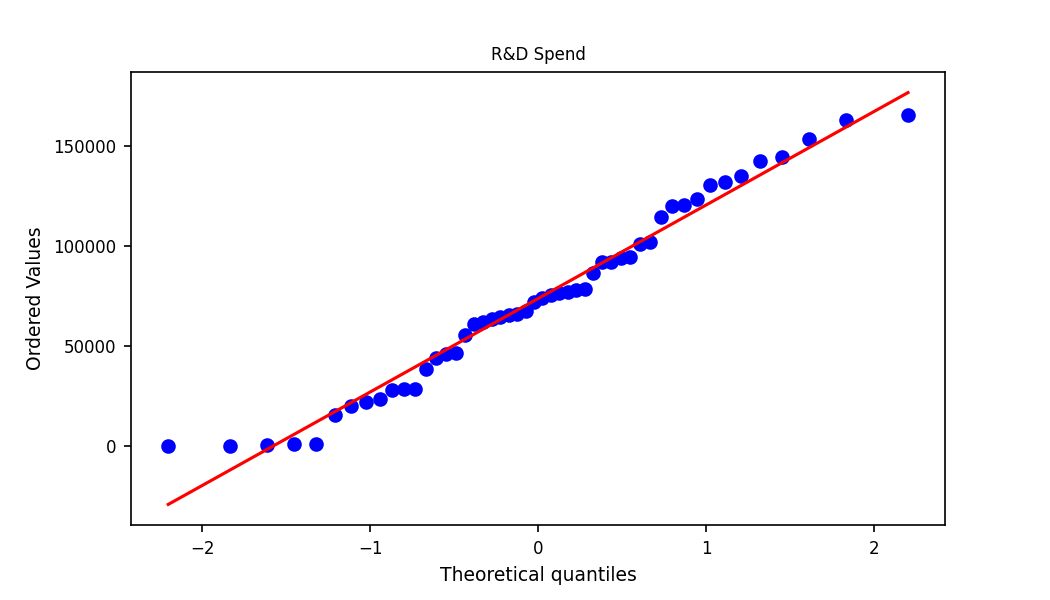

<IPython.core.display.Javascript object>


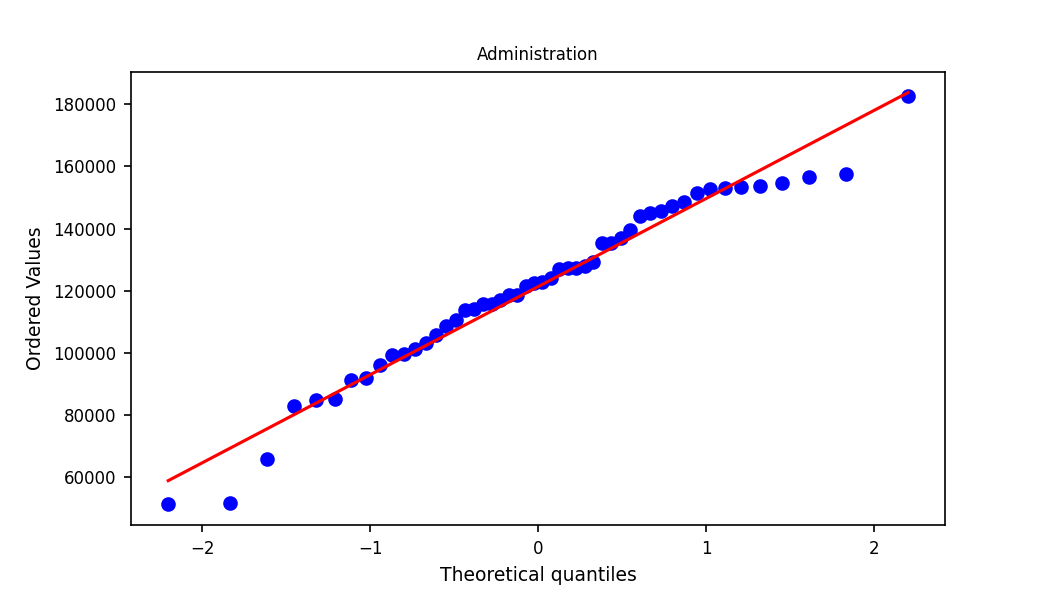

<IPython.core.display.Javascript object>


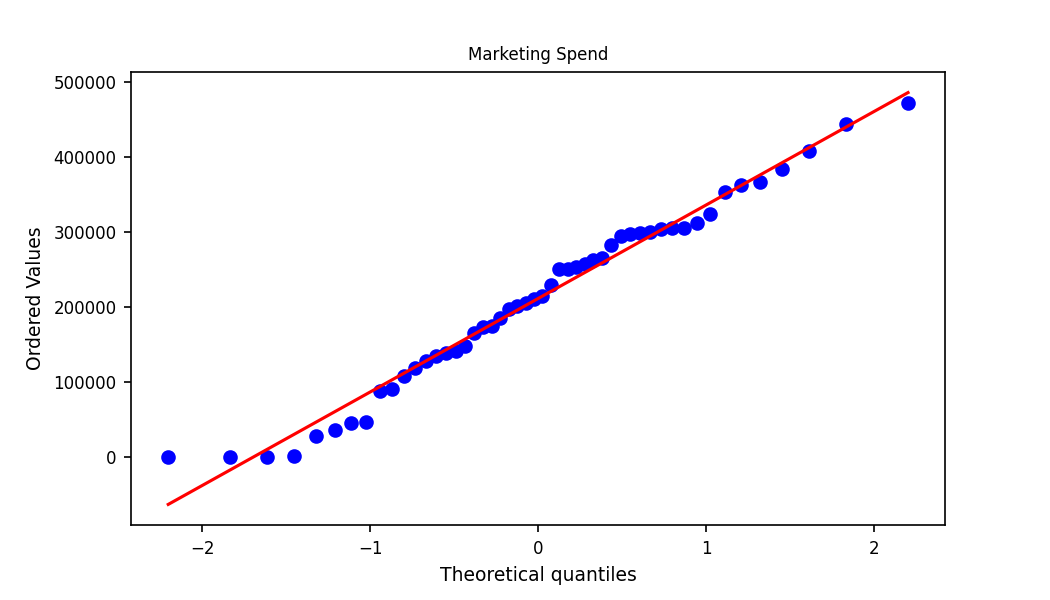

In [57]:
# Normality test using  probability plot:
for col in numeric_cols:
    if col != y_col:
        _, ax = plt.subplots()
        ax = stats.probplot(x=startups_df[col], dist='norm', plot=plt)
        plt.title(col)
plt.show()

### Observations:

We can see the following from the quantile plots:
- From the quantile plot for **R&D spend**, we see that it is **approximately normally distributed**, with **thin tails** on either sides.
- From the quantile plot for **administration spend**, we see that it is **approximately normally distributed**, but with a **left skew** and a **thinner** than normal **tail** at the **right**.
- From the quantile plot for **marketing spend**, we see that it is **approximately normally distributed**, but with a **thinner** than normal **tail** at the **left**.

Thus we can say all numerical features pass normality test. 

### 3. No Multicollinearity

In [58]:
corr_matrix = startups_df[numeric_cols].corr().round(2)
corr_matrix

,R&D Spend,Administration,Marketing Spend,Profit
R&D Spend,1.00,0.24,0.72,0.97
Administration,0.24,1.00,-0.03,0.20
Marketing Spend,0.72,-0.03,1.00,0.75
Profit,0.97,0.20,0.75,1.00


<IPython.core.display.Javascript object>


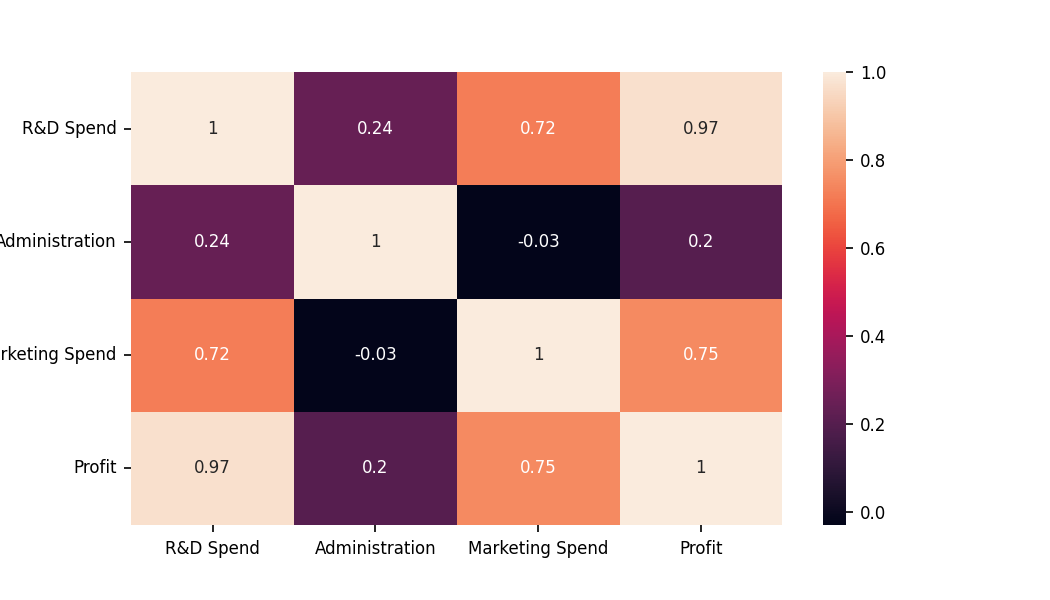

In [59]:
fig,ax = plt.subplots()
sns.heatmap(data=corr_matrix, annot=True)
plt.show()

### Observations:
- Other than the correlation with the target variable(Profit), There seems to be **some correlation between R&D spend and marketing spend**. Since **correlation** coefficient for this pair is **0.72**, which is **less than 0.8**, we can safely **ignore the correlation** and aaume that the input features are independent of one another. Thus the dataset **passes the multicollinearity test.**

Ref:https://towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea

### 4. No autoregression:
Since the data does not have time as a parameter, there is no autoregression and hence this test passes.

## Data preprocessing

### Split data into features and target.
**Note:** Not performing train test split since the number of observations are less (50) 

In [60]:
startups_df1 = startups_df.copy()
X = startups_df1.drop(labels=y_col, axis=1)
y = startups_df1[[y_col]]

### Encoding categorical variables and Standardization of features and target

In [61]:
# One hot encoding of categorical variables
ohe = OneHotEncoder(categories = 'auto', sparse = False) # The categories setting will encode based on unique values.
X_ohe = pd.DataFrame(ohe.fit_transform(X[cat_cols]))
X = pd.concat([X,X_ohe],axis = 1)
X = X.drop(cat_cols,axis=1)
X.head()

,R&D Spend,Administration,Marketing Spend,0,1,2
0,165349.20,136897.80,471784.10,0.0,0.0,1.0
1,162597.70,151377.59,443898.53,1.0,0.0,0.0
2,153441.51,101145.55,407934.54,0.0,1.0,0.0
3,144372.41,118671.85,383199.62,0.0,0.0,1.0
4,142107.34,91391.77,366168.42,0.0,1.0,0.0


In [62]:
# Standardization
X_scaled = X.copy()
y_scaled = y.copy()

std_scaler = StandardScaler()
X_scaled.iloc[:, :-3] = std_scaler.fit_transform(X_scaled.iloc[:, :-3])
y_scaled = pd.DataFrame(std_scaler.fit_transform(y_scaled))

In [63]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
R&D Spend,50.0,73721.6156,45902.256482,0.00,39936.3700,73051.080,101602.800,165349.20
Administration,50.0,121344.6396,28017.802755,51283.14,103730.8750,122699.795,144842.180,182645.56
Marketing Spend,50.0,211025.0978,122290.310726,0.00,129300.1325,212716.240,299469.085,471784.10
0,50.0,0.3400,0.478518,0.00,0.0000,0.000,1.000,1.00
1,50.0,0.3200,0.471212,0.00,0.0000,0.000,1.000,1.00
2,50.0,0.3400,0.478518,0.00,0.0000,0.000,1.000,1.00


In [64]:
X_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
R&D Spend,50.0,1.199041e-16,1.010153,-1.622362,-0.743498,-0.014756,0.613570,2.016411
Administration,50.0,-2.919887e-16,1.010153,-2.525994,-0.635046,0.048859,0.847179,2.210141
Marketing Spend,50.0,-9.325873e-17,1.010153,-1.743127,-0.675071,0.013969,0.730572,2.153943
0,50.0,3.400000e-01,0.478518,0.000000,0.000000,0.000000,1.000000,1.000000
1,50.0,3.200000e-01,0.471212,0.000000,0.000000,0.000000,1.000000,1.000000
2,50.0,3.400000e-01,0.478518,0.000000,0.000000,0.000000,1.000000,1.000000


In [65]:
# Checking for multicollinearity after encoding categorical variable.
corr_matrix = X_scaled.corr().round(2)
corr_matrix

,R&D Spend,Administration,Marketing Spend,0,1,2
R&D Spend,1.00,0.24,0.72,-0.14,0.11,0.04
Administration,0.24,1.00,-0.03,-0.02,0.01,0.01
Marketing Spend,0.72,-0.03,1.00,-0.17,0.21,-0.03
0,-0.14,-0.02,-0.17,1.00,-0.49,-0.52
1,0.11,0.01,0.21,-0.49,1.00,-0.49
2,0.04,0.01,-0.03,-0.52,-0.49,1.00


<IPython.core.display.Javascript object>


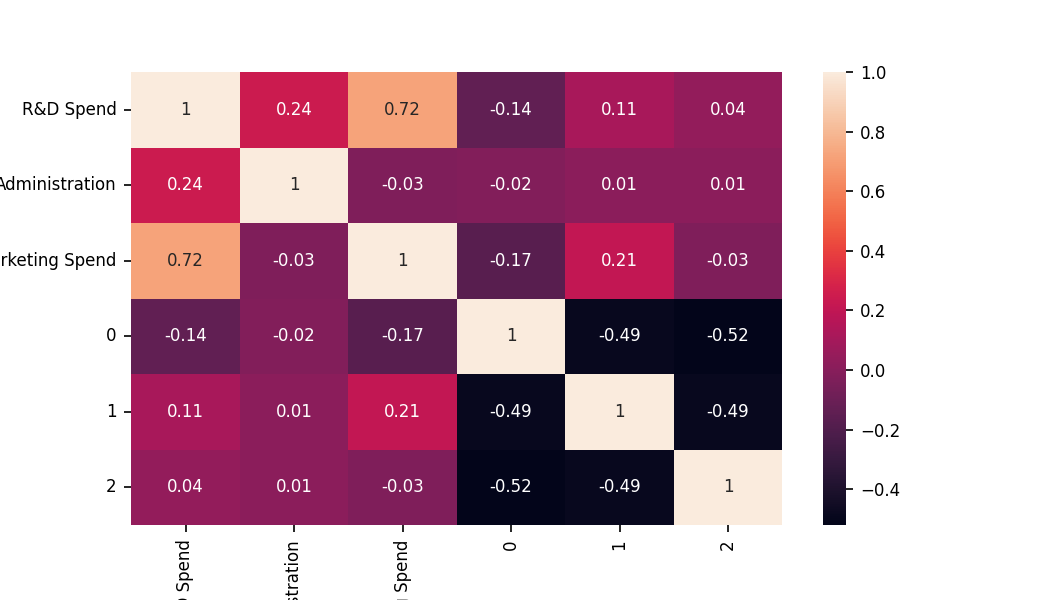

In [66]:
fig,ax = plt.subplots()
sns.heatmap(data=corr_matrix, annot=True)
plt.show()

Other than the previously observed slight collinearity between R&D spend and marketing spend, there are no other pairs with strong collinearity

## Model building using sklearn LinearRegression
Also, Testing for **homoscedasticity and zero residual mean**

### Model building

In [67]:
linear_model_1 = LinearRegression()
linear_model_2 = LinearRegression()
linear_model_1.fit(X,y)
linear_model_2.fit(X_scaled,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Model Evaluation

In [68]:
# Predictions:
y_pred = linear_model_1.predict(X)
y_pred_scaled = linear_model_2.predict(X_scaled)

In [69]:
err = (y - y_pred).to_numpy()
err_scaled = (y - y_pred_scaled).to_numpy()

In [70]:
pred_comparison = pd.concat([y, pd.DataFrame(y_pred, columns=['y_pred']),
                  pd.DataFrame(y_pred_scaled, columns=['y_pred_scaled']),
                  pd.DataFrame(err, columns=['error'])],axis=1) 
pred_comparison.head()

,Profit,y_pred,y_pred_scaled,error
0,192261.83,192390.571363,192390.571363,-128.741363
1,191792.06,189071.320105,189071.320105,2720.739895
2,191050.39,182276.186733,182276.186733,8774.203267
3,182901.99,173584.976190,173584.976190,9317.013810
4,166187.94,172277.133817,172277.133817,-6089.193817


**Note:** error = y_pred - profit (y $\rightarrow$ Profit)

There is almost no difference in the predicted profit for the original and standardized data. Will be considering standardized data for homscadasticity and multicollinearity tests.

### 5. Homoscedasticity 

In [71]:
X_scaled.columns

Index(['R&D Spend', 'Administration', 'Marketing Spend', 0, 1, 2], dtype='object')

<IPython.core.display.Javascript object>


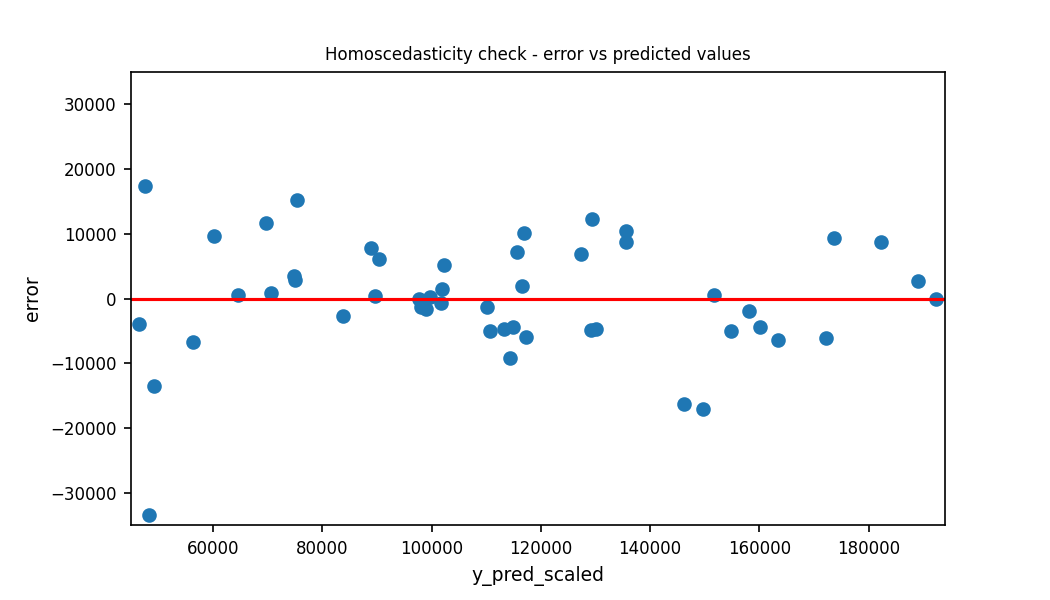

In [72]:
fig,ax = plt.subplots()
ax.scatter(x = y_pred_scaled, y =err_scaled)
ax.set_title('Homoscedasticity check - error vs predicted values')
ax.set_xlabel('y_pred_scaled')
ax.set_ylabel('error')
ax.plot([45000,194000],[0,0], 'r-')
ax.set_xlim(45000,194000)
ax.set_ylim(-35000,35000)
plt.show()

### Observations:
The datapoints are not randomly scattered above and below the zero line, thus **homoscedasticity fails**

### 6. Test for zero residual mean

<IPython.core.display.Javascript object>


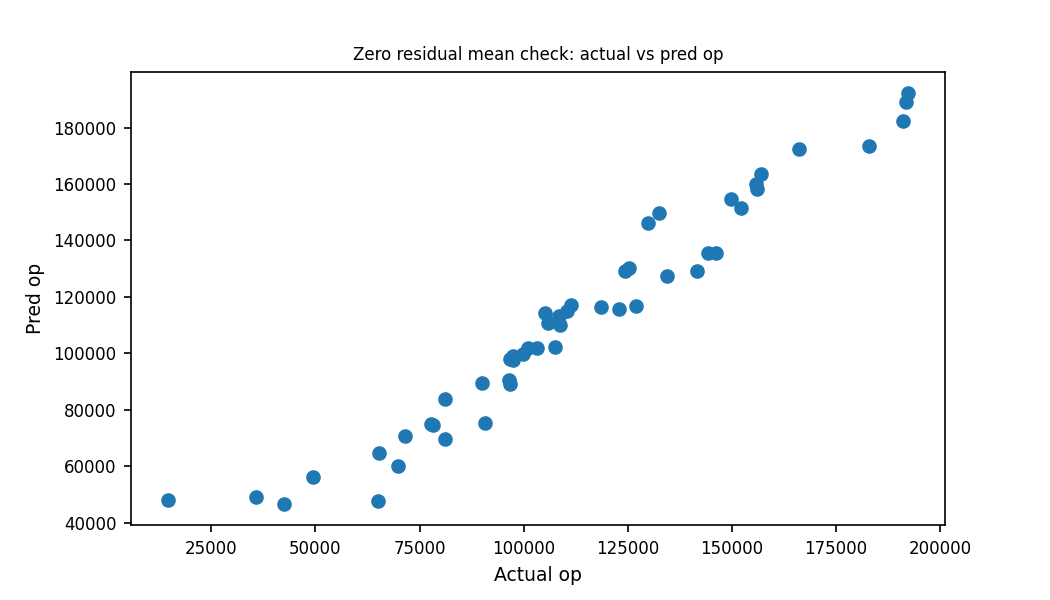

In [73]:
fig,ax = plt.subplots()
plt.scatter(x = y, y =y_pred_scaled)
plt.title('Zero residual mean check: actual vs pred op')
plt.xlabel('Actual op')
plt.ylabel('Pred op')
plt.show()

### Observations:
If we assume an imaginary line placed along the data points, except few points at the bottom left part of the graph, most of the points,seem to cluster around this line. Although the **zero residual** mean plot has some distant points, we can expect to get acceptable predictions, thus we can say that the model passed the zero residual mean test.

## SK learn Linear regression model summary

In [74]:
# Model evaluation:
print("Coefficients for original data    : ", linear_model_1.coef_)
print("\nCoefficients for standardized data: ", linear_model_2.coef_)
# Mean absolute error:
print("\nMean absolute error               : %.2f" % mean_absolute_error(y, y_pred_scaled))
# Mean squared error
print("Mean squared error                : %.2f" % mean_squared_error(y, y_pred_scaled))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination      : %.2f" % r2_score(y, y_pred_scaled))

Coefficients for original data    :  [[ 8.06023114e-01 -2.70043196e-02  2.69798610e-02 -5.23005912e+01
   1.46488202e+02 -9.41876104e+01]]

Coefficients for standardized data:  [[36626.42825194  -748.99746924  3266.21519397   -52.30059124
    146.48820162   -94.18761038]]

Mean absolute error               : 6475.50
Mean squared error                : 78406792.89
Coefficient of determination      : 0.95


### Observations:
We can see from R2 score (0.95) that the linear model fits very well for the given data.

### Linear regression using only the numeric columns:
**Note:** Performed to see the effect of dropping the categorical column, on the linear model.

In [75]:
# Model training and predictions:
linear_model_3 = LinearRegression()
linear_model_3.fit(X.iloc[:,:-3],y)
y_pred_xnum_cols = linear_model_3.predict(X.iloc[:,:-3])

# Model evaluation:
print("Coefficients for original data        : ", linear_model_3.coef_)
# Mean absolute error:
print("\nMean absolute error               : %.2f" % mean_absolute_error(y, y_pred_xnum_cols))
# Mean squared error
print("Mean squared error                : %.2f" % mean_squared_error(y, y_pred_xnum_cols))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination      : %.2f" % r2_score(y, y_pred_xnum_cols))

Coefficients for original data        :  [[ 0.80571505 -0.02681597  0.02722806]]

Mean absolute error               : 6471.45
Mean squared error                : 78417126.02
Coefficient of determination      : 0.95


### Observations:
We can see that there is no significant difference in R2 score (0.95). Therefore dropping the categorical column ("State" in this case) doest not significantly impact final predictions. Also, standardization does not affect R2 score in this case.

## Linear Regression with Statsmodels for evaluation

In [76]:
# Rename columns so as to make it convenient to enter the formula.
startups_df1.rename(columns={'R&D Spend': 'RnD_Spend', 
                             'Marketing Spend':'Marketing_Spend'},
                             inplace = True)

In [77]:
# Check renmed columns.
startups_df1.columns, y.columns

(Index(['RnD_Spend', 'Administration', 'Marketing_Spend', 'State', 'Profit'], dtype='object'),
 Index(['Profit'], dtype='object'))

In [78]:
# Train and predict.
linear_model = smf.ols('Profit ~ RnD_Spend + Administration + Marketing_Spend + C(State)', 
                         data=startups_df1).fit()

In [79]:
linear_model.params

Intercept               50125.343832
C(State)[T.Florida]       198.788793
C(State)[T.New York]      -41.887019
RnD_Spend                   0.806023
Administration             -0.027004
Marketing_Spend             0.026980
dtype: float64

In [80]:
y_pred_lm = linear_model.predict(startups_df1.iloc[:,:-1])

In [81]:
# Evaluation metrics:
print("R2 Score           : ", round(linear_model.rsquared,5))
print("Adjusted R2 score  : ", round(linear_model.rsquared_adj,5))
print("AIC                : ", round(linear_model.aic,4))
print("BIC                : ", round(linear_model.bic,4))

R2 Score           :  0.95075
Adjusted R2 score  :  0.94516
AIC                :  1062.7649
BIC                :  1074.237


### Exploring the contribution on input features, one by one:

In [82]:
model_1 = smf.ols('Profit ~ RnD_Spend', 
                  data=startups_df1).fit()
# Evaluation metrics:
print("R2 Score           : ", round(model_1.rsquared,5))
print("Adjusted R2 score  : ", round(model_1.rsquared_adj,5))
print("AIC                : ", round(model_1.aic,4))
print("BIC                : ", round(model_1.bic,4))

R2 Score           :  0.94654
Adjusted R2 score  :  0.94542
AIC                :  1058.873
BIC                :  1062.6971


In [83]:
model_2 = smf.ols('Profit ~ RnD_Spend + Administration ', 
                  data=startups_df1).fit()
# Evaluation metrics:
print("R2 Score           : ", round(model_2.rsquared,5))
print("Adjusted R2 score  : ", round(model_2.rsquared_adj,5))
print("AIC                : ", round(model_2.aic,4))
print("BIC                : ", round(model_2.bic,4)) # AIC BIC slight Increase, not much change

R2 Score           :  0.94781
Adjusted R2 score  :  0.94559
AIC                :  1059.6637
BIC                :  1065.3998


In [84]:
model_3 = smf.ols('Profit ~ RnD_Spend + Administration + Marketing_Spend', 
                  data=startups_df1).fit()
# Evaluation metrics:
print("R2 Score           : ", round(model_3.rsquared,5))
print("Adjusted R2 score  : ", round(model_3.rsquared_adj,5))
print("AIC                : ", round(model_3.aic,4))
print("BIC                : ", round(model_3.bic,4)) # AIC slight dec, BIC slight Increase

R2 Score           :  0.95075
Adjusted R2 score  :  0.94753
AIC                :  1058.7715
BIC                :  1066.4196


In [85]:
model_4 = smf.ols('Profit ~ Administration + Marketing_Spend + C(State)', 
                  data=startups_df1).fit()
# Evaluation metrics:
print("R2 Score           : ", round(model_4.rsquared,5)) # R2 and Adj R2 decrease
print("Adjusted R2 score  : ", round(model_4.rsquared_adj,5))
print("AIC                : ", round(model_4.aic,4))
print("BIC                : ", round(model_4.bic,4)) # AIC BIC Increase

R2 Score           :  0.61311
Adjusted R2 score  :  0.57872
AIC                :  1163.8293
BIC                :  1173.3894


### Observations:
- Strong contribution from R&D spend followed by minor contribution from marketing spend and administration

### Feature Selection
**Hypothesis**

**H0:** The feature is not significant

**Ha:** The feature is significant

Level of significance: 5%


In [86]:
linear_model.pvalues

Intercept               4.444178e-09
C(State)[T.Florida]     9.532429e-01
C(State)[T.New York]    9.897941e-01
RnD_Spend               2.578772e-21
Administration          6.077373e-01
Marketing_Spend         1.226769e-01
dtype: float64

In [87]:
model_5 = smf.ols('Profit ~ Administration', data=startups_df1).fit()
model_5.pvalues

Intercept         0.003824
Administration    0.162217
dtype: float64

In [88]:
model_6 = smf.ols('Profit ~ Marketing_Spend', data=startups_df1).fit()
model_5.pvalues

Intercept         0.003824
Administration    0.162217
dtype: float64

In [89]:
model_7 = smf.ols('Profit ~ RnD_Spend + Administration', data=startups_df1).fit()
model_7.pvalues

Intercept         5.695336e-12
RnD_Spend         2.278348e-31
Administration    2.888932e-01
dtype: float64

In [90]:
# Evaluation metrics:
print("R2 Score           : ", round(model_7.rsquared,5))
print("Adjusted R2 score  : ", round(model_7.rsquared_adj,5))
print("AIC                : ", round(model_7.aic,4))
print("BIC                : ", round(model_7.bic,4)) # AIC slight dec, BIC slight Increase

R2 Score           :  0.94781
Adjusted R2 score  :  0.94559
AIC                :  1059.6637
BIC                :  1065.3998


In [91]:
model_8 = smf.ols('Profit ~ RnD_Spend + Marketing_Spend', data=startups_df1).fit()
model_8.pvalues

Intercept          3.504062e-22
RnD_Spend          6.040433e-24
Marketing_Spend    6.003040e-02
dtype: float64

In [92]:
model_8 = smf.ols('Profit ~ RnD_Spend + Marketing_Spend', data=startups_df1).fit()
# Evaluation metrics:
print("R2 Score           : ", round(model_8.rsquared,5))
print("Adjusted R2 score  : ", round(model_8.rsquared_adj,5))
print("AIC                : ", round(model_8.aic,4))
print("BIC                : ", round(model_8.bic,4)) # AIC slight dec, BIC slight Increase

R2 Score           :  0.95045
Adjusted R2 score  :  0.94834
AIC                :  1057.0708
BIC                :  1062.8068


### Observations
- **Contribution of R&D spend to profit is dominant** since it alone makes R2 and adj R2 approach 0.95 (close to 1).
- From the p values, we see that **categorical column does not contribute to the model**. The p values are greater than 0.05, thus it can be **dropped**.

- When administration and marketing spend are taken individually, they have the same pvalues. When combined with R&D spend, they provide R2 = 0.95075, and adjusted R2 = 0.9475 and coreesponding AIC ~1059 and BIC ~ 1066.

- When **Administration is combined with R&D spend, both R2 and adjusted R2 scores decrease slightly**. Also, from pvalues, we can infer its conribution to be **not significant since ~ 0.3 >> 0.05**.

- When **Marketing_Spend is combined with R&D spend, both R2 and adjusted R2 scores increases**. Also, from pvalues, we can infer its conribution, although **not significant at  5%**, since ~ 0.06 > 0.05, it is **significant at 10%**, thus we can include marketing spend for a **slight gain in accuracy**. Also, the AIC and BIC score is the lowest in this case.

In [93]:
summary = {"Metrics":['R2 Score','Adj_R2 score','AIC','BIC'],
           "linear_model":[round(linear_model.rsquared,5),round(linear_model.rsquared_adj,5),round(linear_model.aic,4),round(linear_model.bic,4)],
           "model_1": [round(model_1.rsquared,5),round(model_1.rsquared_adj,5),round(model_1.aic,4),round(model_1.bic,4)],
           "model_3": [round(model_3.rsquared,5),round(model_3.rsquared_adj,5),round(model_3.aic,4),round(model_3.bic,4)],
           "model_7": [round(model_7.rsquared,5),round(model_7.rsquared_adj,5),round(model_7.aic,4),round(model_7.bic,4)],
           "model_8": [round(model_8.rsquared,5),round(model_8.rsquared_adj,5),round(model_8.aic,4),round(model_8.bic,4)],
           }

In [94]:
summary_df = pd.DataFrame(summary).set_index("Metrics")
summary_df

,linear_model,model_1,model_3,model_7,model_8
Metrics,,,,,
R2 Score,0.95075,0.94654,0.95075,0.94781,0.95045
Adj_R2 score,0.94516,0.94542,0.94753,0.94559,0.94834
AIC,1062.76490,1058.87300,1058.77150,1059.66370,1057.07080
BIC,1074.23700,1062.69710,1066.41960,1065.39980,1062.80680


**Key:**
- linear_model : Model built using full data.
- model_1      : Model built using only the feature - R&D.
- model_3      : Model built using only numerical features ("State" column is dropped)  
- model_7      : Model built using freatures R&D and Administration.
- model_8      : Model built using freatures R&D and Marketing spend.



## Conclusion:
From the above analysis, we see that, without significant loss in accuracy, the final could be built with only R&D spend and Marketing spend. This implies that the profit a startup could eventually make hugely depends on how much it spends on R&D, and to a minor extent on marketing.